analyze NCI cervical cnv results

In [73]:
# import csv
import matplotlib
# import seaborn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from scipy.stats import ttest_ind
# import scipy.stats as stats
# import scipy.stats as ss
# from matplotlib import style
# import matplotlib.gridspec as gridspec
# import matplotlib.patches as patches
matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6, 4)
from adjustText import adjust_text
import sys
sys.path.append('/projects/trans_scratch/validations/workspace/szong/Cervical/notebook')
import sz_toolbox as szt


# from sklearn.decomposition import RandomizedPCA, PCA, TruncatedSVD
# from sklearn.linear_model import LogisticRegression
# from sklearn.manifold import TSNE
# from sklearn.preprocessing import StandardScaler

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

copy number comparison:
    
hiv+ vs hiv-

tcga vs hiv-

# 1. produce list of amplied and deleted regions with oncogenes

In [76]:
root = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/gatk_cnv/'
outputdir = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/gatk_cnv/shared_uniq_genes/'
oncogenef = '/home/szong/projects/resource/oncogenes.and.tumor.suppressor.genes.txt'
gistdir = '/home/szong/bin/GISTIC_2_0_22/gatk_118_HIV_pos/'

In [13]:
# get list of oncogenes and tumour suppressors
tgs = pd.read_csv(oncogenef, header=None)[0].tolist()
tgs[:2]

['ABI1', 'ABI2']

In [48]:
def summarize_genes(inf, tgs, wkdir):
    df = pd.read_csv(inf, sep='\t', header=None)#.replace('', 'None')
    inf = inf.split('/')[-1]
#     print(df)
    df.loc['genes',:] = df.apply(lambda x:  ','.join([i.strip() for i in set(x[~x.isnull()][4:]) if ('[' not in i)]))
    df.loc['tg_genes',:] = df.apply(lambda x:  ','.join([m.strip() for m in set(x[~x.isnull()][4:]) if m in tgs]))
    df1 = df.loc[[0,1,2,3,'genes', 'tg_genes'],:].T
    df1['xxx'] = df1.genes.apply(lambda x: x.split(','))
#     '' in the list when there is a blank in the original files, must have a better way to deal with this
    df1['num_genes'] = df1['xxx'].apply(lambda x: len(x) if '' not in x else len(x)-1)
    df1 = df1.drop('xxx', axis=1)
    df1 = df1.drop(0)
    df1 = df1[:-1]
    df1.columns = ['cytoband', 'q_value', 'residual_q_value', 'wide_peak_boundary', 'genes_in_wide_peak','oncogenes','num_genes']
#     df1['cancer_genes'] = df1.apply(lambda x: '({0}){1}'.format(x[4], x[5]), axis=1)
    of = f'{wkdir}{inf}.summary'
    print('write summary to: ', of)
    df1.to_csv(of, index=False, sep='\t')
    return df1

In [59]:
def get_qvalue_cytoband(f):
    df = pd.read_csv(f, sep='\t')
    df.columns = ['cytoband', 'q_value', 'residual_q_value', 'chrom', 'wide_peak_boundary', 'genes_in_wide_peak','oncogenes','num_genes']
#     print(df.head(2), df.shape, df.columns)
    df['gene'] = df['genes_in_wide_peak']#.apply(lambda x: x.split(',')[0])
    df = df[['q_value','cytoband', 'gene']]
    df = df[df.gene != '']
    s = df["gene"].str.split(',', expand=True).stack()
    i = s.index.get_level_values(0)
    df2 = df.loc[i].copy()
    df2["gene"] = s.values
    return df2

# 2. parse conf_99 files

In [87]:
# hiv +
wkdir = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/gatk_118_HIV_pos/'
gistdir = '/home/szong/bin/GISTIC_2_0_22/gatk_118_HIV_pos/'
files = [f'{gistdir}amp_genes.conf_99.txt', f'{gistdir}del_genes.conf_99.txt']
for inf in files:
    df1 = summarize_genes(inf, tgs, wkdir)

write summary to:  /projects/trans_scratch/validations/workspace/szong/Cervical/cnv/gatk_118_HIV_pos/amp_genes.conf_99.txt.summary
write summary to:  /projects/trans_scratch/validations/workspace/szong/Cervical/cnv/gatk_118_HIV_pos/del_genes.conf_99.txt.summary


In [88]:
%%bash -s $wkdir
cd $1
cat del_genes.conf_99.txt.summary |awk -F ":" '{print $1"\t"$2}'|sed 's/chr//g'|sort -k4n> del_genes.conf_99.txt.summary.sorted
cat amp_genes.conf_99.txt.summary |awk -F ":" '{print $1"\t"$2}'|sed 's/chr//g'|sort -k4n> amp_genes.conf_99.txt.summary.sorted

In [89]:
# for amps
pos_amp_file = f'{wkdir}/amp_genes.conf_99.txt.summary.sorted'
print(pos_amp_file)
pos_amps = get_qvalue_cytoband(pos_amp_file)
pos_amps.head(2)

/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/gatk_118_HIV_pos//amp_genes.conf_99.txt.summary.sorted


,q_value,cytoband,gene
0,0.015552,1p32.1,EFCAB7
0,0.015552,1p32.1,TM2D1


In [90]:
# for dels
pos_del_file = f'{wkdir}/del_genes.conf_99.txt.summary.sorted'
print(pos_del_file)
pos_dels = get_qvalue_cytoband(pos_del_file)
pos_dels.head(2)

/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/gatk_118_HIV_pos//del_genes.conf_99.txt.summary.sorted


,q_value,cytoband,gene
0,1.043200e-15,2q22.1,LRP1B
0,1.043200e-15,2q22.1,LOC647012


In [91]:
#hiv -
wkdir = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/gatk_118_HIV_neg/'
gistdir = '/home/szong/bin/GISTIC_2_0_22/gatk_118_HIV_neg/'
files = [f'{gistdir}amp_genes.conf_99.txt', f'/{gistdir}/del_genes.conf_99.txt']
for inf in files:
    df1 = summarize_genes(inf, tgs, wkdir)

write summary to:  /projects/trans_scratch/validations/workspace/szong/Cervical/cnv/gatk_118_HIV_neg/amp_genes.conf_99.txt.summary
write summary to:  /projects/trans_scratch/validations/workspace/szong/Cervical/cnv/gatk_118_HIV_neg/del_genes.conf_99.txt.summary


In [92]:
%%bash -s $wkdir
cd $1
cat del_genes.conf_99.txt.summary |awk -F ":" '{print $1"\t"$2}'|sed 's/chr//g'|sort -k4n> del_genes.conf_99.txt.summary.sorted
cat amp_genes.conf_99.txt.summary |awk -F ":" '{print $1"\t"$2}'|sed 's/chr//g'|sort -k4n> amp_genes.conf_99.txt.summary.sorted

In [93]:
neg_amp_file = f'{wkdir}/amp_genes.conf_99.txt.summary.sorted'
print(neg_amp_file)
neg_amps = get_qvalue_cytoband(neg_amp_file)
neg_amps.head(2)

/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/gatk_118_HIV_neg//amp_genes.conf_99.txt.summary.sorted


,q_value,cytoband,gene
0,0.008915,1q21.3,FCGR1A
0,0.008915,1q21.3,FLAD1


In [94]:
neg_del_file = f'{wkdir}/del_genes.conf_99.txt.summary.sorted'
print(neg_del_file)
neg_dels = get_qvalue_cytoband(neg_del_file)
neg_dels.head(2)

/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/gatk_118_HIV_neg//del_genes.conf_99.txt.summary.sorted


,q_value,cytoband,gene
0,0.036117,1p13.2,FCGR1A
0,0.036117,1p13.2,NBPF10


In [95]:
#tcga
wkdir = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/tcga/'
gistdir = '/home/szong/bin/GISTIC_2_0_22/tcga/'
files = [f'{gistdir}amp_genes.conf_99.txt', f'/{gistdir}/del_genes.conf_99.txt']
for inf in files:
    df1 = summarize_genes(inf, tgs, wkdir)

write summary to:  /projects/trans_scratch/validations/workspace/szong/Cervical/cnv/tcga/amp_genes.conf_99.txt.summary
write summary to:  /projects/trans_scratch/validations/workspace/szong/Cervical/cnv/tcga/del_genes.conf_99.txt.summary


In [96]:
%%bash -s $wkdir
cd $1
cat del_genes.conf_99.txt.summary |awk -F ":" '{print $1"\t"$2}'|sed 's/chr//g'|sort -k4n> del_genes.conf_99.txt.summary.sorted
cat amp_genes.conf_99.txt.summary |awk -F ":" '{print $1"\t"$2}'|sed 's/chr//g'|sort -k4n> amp_genes.conf_99.txt.summary.sorted

In [97]:
tcga_amp_file = f'{wkdir}/amp_genes.conf_99.txt.summary.sorted'
print(tcga_amp_file)
tcga_amps = get_qvalue_cytoband(tcga_amp_file)
tcga_amps.head(2)

tcga_del_file = f'{wkdir}/del_genes.conf_99.txt.summary.sorted'
print(tcga_del_file)
tcga_dels = get_qvalue_cytoband(tcga_del_file)
tcga_dels.head(2)

/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/tcga//amp_genes.conf_99.txt.summary.sorted


,q_value,cytoband,gene
0,9.721100e-11,3q26.31,PIK3CA
0,9.721100e-11,3q26.31,ACTL6A


/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/tcga//del_genes.conf_99.txt.summary.sorted


,q_value,cytoband,gene
0,0.001365,1p36.22,CLSTN1
0,0.001365,1p36.22,PRAMEF6


# 3. shared unique genes

In [98]:
# hiv + and -
pos_amps_genes = pos_amps['gene'].tolist()
pos_amps_genes[:2]

# hiv + and -
neg_amps_genes = neg_amps['gene'].tolist()
neg_amps_genes[:2]

of = f'{outputdir}hiv_pos_uniq_amp_genes_pos_vs_neg.txt'
pos_uniq_amp_genes = szt.unique2a(pos_amps_genes, neg_amps_genes)
len(pos_uniq_amp_genes)
szt.list2csv(pos_uniq_amp_genes, of)
of = f'{outputdir}hiv_neg_uniq_amp_genes_pos_vs_neg.txt'
neg_uniq_amp_genes = szt.unique2a(neg_amps_genes,pos_amps_genes)
szt.list2csv(neg_uniq_amp_genes, of)

['EFCAB7', 'TM2D1']

['FCGR1A', 'FLAD1']

399

In [99]:
# hiv + and -
pos_dels_genes = pos_dels['gene'].tolist()
pos_dels_genes[:2]

# hiv + and -
neg_dels_genes = neg_dels['gene'].tolist()
neg_dels_genes[:2]

of = f'{outputdir}hiv_pos_uniq_del_genes_pos_vs_neg.txt'
pos_uniq_del_genes = szt.unique2a(pos_dels_genes, neg_dels_genes)
len(pos_uniq_del_genes)
szt.list2csv(pos_uniq_del_genes, of)
of = f'{outputdir}hiv_neg_uniq_del_genes_pos_vs_neg.txt'
neg_uniq_del_genes = szt.unique2a(neg_dels_genes,pos_dels_genes)
szt.list2csv(neg_uniq_del_genes, of)

['LRP1B', 'LOC647012']

['FCGR1A', 'NBPF10']

3405

In [100]:
# tcga + and hiv-
tcga_amps_genes = tcga_amps['gene'].tolist()
tcga_amps_genes[:2]

neg_amps_genes = neg_amps['gene'].tolist()
neg_amps_genes[:2]

of = f'{outputdir}hiv_tcga_uniq_amp_genes_tcga_vs_neg.txt'
tcga_uniq_amp_genes = szt.unique2a(tcga_amps_genes, neg_amps_genes)
len(tcga_uniq_amp_genes)
szt.list2csv(tcga_uniq_amp_genes, of)
of = f'{outputdir}hiv_neg_uniq_amp_genes_tcga_vs_neg.txt'
neg_uniq_amp_genes = szt.unique2a(neg_amps_genes,tcga_amps_genes)
szt.list2csv(neg_uniq_amp_genes, of)

['PIK3CA', 'ACTL6A']

['FCGR1A', 'FLAD1']

287

In [101]:
# tcga + and hiv-
tcga_dels_genes = tcga_dels['gene'].tolist()
tcga_dels_genes[:2]

neg_dels_genes = neg_dels['gene'].tolist()
neg_dels_genes[:2]

of = f'{outputdir}hiv_tcga_uniq_del_genes_tcga_vs_neg.txt'
tcga_uniq_del_genes = szt.unique2a(tcga_dels_genes, neg_dels_genes)
len(tcga_uniq_del_genes)
szt.list2csv(tcga_uniq_del_genes, of)
of = f'{outputdir}hiv_neg_uniq_del_genes_tcga_vs_neg.txt'
neg_uniq_del_genes = szt.unique2a(neg_dels_genes,tcga_dels_genes)
szt.list2csv(neg_uniq_del_genes, of)

['CLSTN1', 'PRAMEF6']

['FCGR1A', 'NBPF10']

2239

# 3. summarize cytobands

In [145]:
ndf = pd.merge(pos_amps, neg_amps, left_on='cytoband', right_on='cytoband', how='outer')#.fillna(1)
ndf.head(2)

new_cols = pd.Series(ndf.columns.tolist()).str.replace('_x', '_hiv+').str.replace('_y', '_hiv-')

ndf.columns = new_cols
ndf = ndf.drop_duplicates(subset='cytoband', keep='last')

ndf.head(2)
ndf.shape
ndf['cytoband'].nunique()
ndf['q_value_hiv+'] = ndf['q_value_hiv+'].fillna(1)
ndf['q_value_hiv-'] = ndf['q_value_hiv-'].fillna(1)
ndf['hiv+q(-log10)'] = -np.log10(ndf['q_value_hiv+'])
ndf['hiv-q(-log10)'] = -np.log10(ndf['q_value_hiv-'])
# ndf['num_genes_hiv+'] = ndf['num_genes_hiv+'].fillna(0).astype(int)
# ndf['num_genes_hiv-'] = ndf['num_genes_hiv-'].fillna(0).astype(int)
# ndf['oncogenes_hiv+'] = ndf['oncogenes_hiv+'].fillna('None')
# ndf['oncogenes_hiv-'] = ndf['oncogenes_hiv-'].fillna('None')
ndf.head(2)

,q_value_x,cytoband,gene_x,q_value_y,gene_y
0,0.015552,1p32.1,TACSTD2,NaN,NaN
1,0.015552,1p32.1,L1TD1,NaN,NaN


,q_value_hiv+,cytoband,gene_hiv+,q_value_hiv-,gene_hiv-
28,0.015552,1p32.1,ATG4C,NaN,NaN
61,0.020664,2p11.2,C2orf89,NaN,NaN


(15, 5)

15

,q_value_hiv+,cytoband,gene_hiv+,q_value_hiv-,gene_hiv-,hiv+q(-log10),hiv-q(-log10)
28,0.015552,1p32.1,ATG4C,1.0,NaN,1.808214,-0.0
61,0.020664,2p11.2,C2orf89,1.0,NaN,1.684786,-0.0


Text(0.5, 1.0, 'GISTIC amps cytobands')

Text(0.5, 0, 'HIV-(-log10)')

Text(0, 0.5, 'HIV+(-log10)')

(-1, 10)

(-1, 10)

65

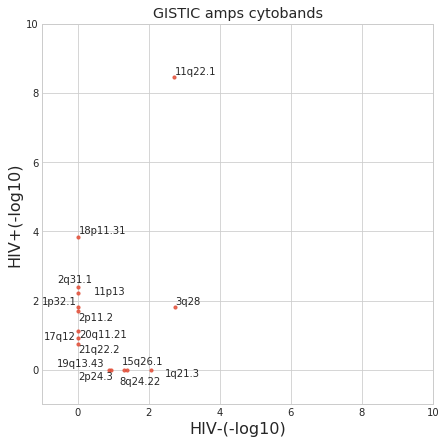

In [147]:
# Set theme
sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(7, 7))
sns.regplot(x='hiv-q(-log10)', y='hiv+q(-log10)', data=ndf, ax=ax, fit_reg=False,  scatter_kws={"s": 10})#x_jitter=1e-12, y_jitter=1e-10,

ax.set_title('GISTIC amps cytobands')
ax.set_xlabel('HIV-(-log10)', fontsize=16)
ax.set_ylabel('HIV+(-log10)', fontsize=16)

ax.set_xlim(-1, 10)
ax.set_ylim(-1, 10)

texts = [plt.text(a, b, c) for a, b, c in zip(ndf['hiv-q(-log10)'], ndf['hiv+q(-log10)'], ndf.cytoband)]
adjust_text(texts)

of = f'{root}amp_cytoband_qvalue_comparison_hiv_pos_vs_neg.png'
plt.savefig(of, bbox_inches='tight', dpi=200)

In [148]:
ndf = pd.merge(pos_dels, neg_dels, left_on='cytoband', right_on='cytoband', how='outer')#.fillna(1)
ndf.head(2)

new_cols = pd.Series(ndf.columns.tolist()).str.replace('_x', '_hiv+').str.replace('_y', '_hiv-')

ndf.columns = new_cols
ndf = ndf.drop_duplicates(subset='cytoband', keep='last')

ndf.head(2)
ndf.shape
ndf['cytoband'].nunique()
ndf['q_value_hiv+'] = ndf['q_value_hiv+'].fillna(1)
ndf['q_value_hiv-'] = ndf['q_value_hiv-'].fillna(1)
ndf['hiv+q(-log10)'] = -np.log10(ndf['q_value_hiv+'])
ndf['hiv-q(-log10)'] = -np.log10(ndf['q_value_hiv-'])
# ndf['num_genes_hiv+'] = ndf['num_genes_hiv+'].fillna(0).astype(int)
# ndf['num_genes_hiv-'] = ndf['num_genes_hiv-'].fillna(0).astype(int)
# ndf['oncogenes_hiv+'] = ndf['oncogenes_hiv+'].fillna('None')
# ndf['oncogenes_hiv-'] = ndf['oncogenes_hiv-'].fillna('None')
ndf.head(2)

,q_value_x,cytoband,gene_x,q_value_y,gene_y
0,1.043200e-15,2q22.1,LOC647012,0.04368,NXPH2
1,1.043200e-15,2q22.1,LOC647012,0.04368,KYNU


,q_value_hiv+,cytoband,gene_hiv+,q_value_hiv-,gene_hiv-
153,1.043200e-15,2q22.1,LRP1B,0.04368,CXCR4
488,1.519500e-09,2q36.3,PDE6D,NaN,NaN


(36, 5)

36

,q_value_hiv+,cytoband,gene_hiv+,q_value_hiv-,gene_hiv-,hiv+q(-log10),hiv-q(-log10)
153,1.043200e-15,2q22.1,LRP1B,0.04368,CXCR4,14.981632,1.359717
488,1.519500e-09,2q36.3,PDE6D,1.00000,NaN,8.818299,-0.000000


In [133]:
ndf[(ndf['q_value_hiv+'] >0.25)&(ndf['q_value_hiv-']<0.25)].shape

(19, 7)

Text(0.5, 0, 'HIV-(-log10)')

Text(0, 0.5, 'HIV+(-log10)')

Text(0.5, 1.0, 'GISTIC dels cytobands')

(-1, 16)

(-1, 16)

290

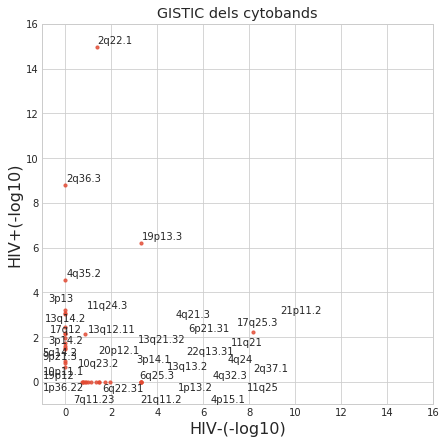

In [150]:
# Set theme
sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(7, 7))
sns.regplot(x='hiv-q(-log10)', y='hiv+q(-log10)', data=ndf, ax=ax, fit_reg=False,  scatter_kws={"s": 10})#x_jitter=1e-12, y_jitter=1e-10,
ax.set_xlabel('HIV-(-log10)', fontsize=16)
ax.set_ylabel('HIV+(-log10)', fontsize=16)
ax.set_title('GISTIC dels cytobands')
ax.set_xlim(-1, 16)
ax.set_ylim(-1, 16)

texts = [plt.text(a, b, c) for a, b, c in zip(ndf['hiv-q(-log10)'], ndf['hiv+q(-log10)'], ndf.cytoband)]
adjust_text(texts)

of = f'{root}del_cytoband_qvalue_comparison_hiv_pos_vs_neg.png'
plt.savefig(of, bbox_inches='tight', dpi=200)

# LOOK AT OVERALL COPY NUMBER CHANGES IN SMGS

In [151]:
smgf = '/projects/trans_scratch/validations/workspace/szong/Cervical/mutsig2cv/118_patients/smgs.txt'
smgs = pd.read_csv(smgf, header=None, comment='#')[0].tolist()
smgs = smgs + ['BAGE']

In [193]:
posf = '/projects/trans_scratch/validations/workspace/szong/Cervical/73_hiv_positive_patients.txt'
negf = '/projects/trans_scratch/validations/workspace/szong/Cervical/45_hiv_negative_patients.txt'
pos = pd.read_csv(posf, header=None)[0].tolist()
pos[:2]
pos.remove('HTMCP-03-06-02344')
len(pos)
neg = pd.read_csv(negf, header=None)[0].tolist()
neg[:2]
neg.remove('HTMCP-03-06-02210')
len(neg)

['HTMCP-03-06-02001', 'HTMCP-03-06-02003']

72

['HTMCP-03-06-02002', 'HTMCP-03-06-02006']

44

In [194]:
f = '/home/szong/bin/GISTIC_2_0_22/gatk_118_patients/focal_data_by_genes.txt'
df = pd.read_csv(f, sep='\t', low_memory=False)
df.head(2)
df.shape
#why two patients missing

,Gene Symbol,Locus ID,Cytoband,HTMCP-03-06-02256,HTMCP-03-06-02332,HTMCP-03-06-02414,HTMCP-03-06-02435,HTMCP-03-06-02261,HTMCP-03-06-02175,HTMCP-03-06-02098,...,HTMCP-03-06-02148,HTMCP-03-06-02176,HTMCP-03-06-02174,HTMCP-03-06-02239,HTMCP-03-06-02354,HTMCP-03-06-02259,HTMCP-03-06-02180,HTMCP-03-06-02213,HTMCP-03-06-02179,HTMCP-03-06-02001
0,ACAP3,116983,1p36.33,0.0,-0.121,0.0,0.0,0.0,-0.829,0.0,...,0.0,0.0,0.0,0.0,-0.251,0.0,-0.644,0.0,0.0,0.0
1,ACTRT2,140625,1p36.32,0.0,-0.121,0.0,0.0,0.0,-0.829,0.0,...,0.0,0.0,0.0,0.0,-0.251,0.0,-0.644,0.0,0.0,0.0


(23109, 119)

In [186]:
df.head()

,Gene Symbol,Locus ID,Cytoband,HTMCP-03-06-02256,HTMCP-03-06-02332,HTMCP-03-06-02414,HTMCP-03-06-02435,HTMCP-03-06-02261,HTMCP-03-06-02175,HTMCP-03-06-02098,...,HTMCP-03-06-02148,HTMCP-03-06-02176,HTMCP-03-06-02174,HTMCP-03-06-02239,HTMCP-03-06-02354,HTMCP-03-06-02259,HTMCP-03-06-02180,HTMCP-03-06-02213,HTMCP-03-06-02179,HTMCP-03-06-02001
0,ACAP3,116983,1p36.33,0.0,-0.121,0.0,0.0,0.0,-0.829,0.0,...,0.0,0.0,0.0,0.0,-0.251,0.0,-0.644,0.0,0.0,0.0
1,ACTRT2,140625,1p36.32,0.0,-0.121,0.0,0.0,0.0,-0.829,0.0,...,0.0,0.0,0.0,0.0,-0.251,0.0,-0.644,0.0,0.0,0.0
2,AGRN,375790,1p36.33,0.0,-0.121,0.0,0.0,0.0,-0.829,0.0,...,0.0,0.0,0.0,0.0,-0.251,0.0,-0.644,0.0,0.0,0.0
3,ANKRD65,441869,1p36.33,0.0,-0.121,0.0,0.0,0.0,-0.829,0.0,...,0.0,0.0,0.0,0.0,-0.251,0.0,-0.644,0.0,0.0,0.0
4,ARHGEF16,27237,1p36.32,0.0,-0.121,0.0,0.0,0.0,-0.829,0.0,...,0.0,0.0,0.0,0.0,-0.251,0.0,-0.644,0.0,0.0,0.0


In [195]:

df = df[df['Gene Symbol'].isin(smgs)].drop(['Locus ID', 'Cytoband'], axis=1).set_index('Gene Symbol').astype(float)
smgdf = df[neg]
smgdf.shape

(13, 44)

In [196]:
smgdf[:2]

,HTMCP-03-06-02002,HTMCP-03-06-02006,HTMCP-03-06-02008,HTMCP-03-06-02012,HTMCP-03-06-02013,HTMCP-03-06-02036,HTMCP-03-06-02037,HTMCP-03-06-02040,HTMCP-03-06-02042,HTMCP-03-06-02046,...,HTMCP-03-06-02215,HTMCP-03-06-02222,HTMCP-03-06-02256,HTMCP-03-06-02264,HTMCP-03-06-02266,HTMCP-03-06-02322,HTMCP-03-06-02326,HTMCP-03-06-02328,HTMCP-03-06-02332,HTMCP-03-06-02333
Gene Symbol,,,,,,,,,,,,,,,,,,,,,
ZC3H6,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0
CASP8,0.0,0.0,0.0,0.0,0.0,-0.73,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.756,0.0,0.0


In [197]:
s1 = (smgdf >0.1).sum(axis=1).to_frame()
s1.columns = ['amp']
s2 = (smgdf <-0.1).sum(axis=1).to_frame()
s2.columns = ['del']
smg_copies = pd.merge(s1, s2, left_index=True, right_index=True)
smg_copies.to_csv(f'{root}cnvs_of_smgs.txt', sep='\t')

In [198]:
smg_copies

,amp,del
Gene Symbol,,
ZC3H6,0,1
CASP8,0,2
PIK3CA,9,0
FBXW7,1,1
FAT1,0,2
PCDHA9,1,0
PCDHGA12,1,0
SLC35G5,3,0
MLL2,5,2


# detour to see if intergration sites clustered in the arms or cytobands with copy number significantly altered

In [75]:
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/integration/124_patients/DNA_integration_results.txt'
df = pd.read_csv(f, sep='\t')
df.head(2)
df.shape

,library,virus,Integration,human-breakpoint,human-gene(s)
0,HTMCP_719,No-Hits,NO,-,-
1,HTMCP_716,Human papillomavirus type 18,YES,X_97127953,intergenic


(424, 5)

In [103]:
dfintg = df[df.Integration=="YES"]
dfintg.shape

(332, 5)

In [104]:
# find hiv+ patients
f1 = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/118_patients/73_hiv_pos_pats.txt'
pos_pats = pd.read_csv(f1, sep='\t', header=None)[2].tolist()
pos_pats[:2]

['HTMCP_124', 'HTMCP_126']

In [105]:
dfintg_pos = dfintg[dfintg.library.isin(pos_pats)]
dfintg_pos[:2]

,library,virus,Integration,human-breakpoint,human-gene(s)
1,HTMCP_716,Human papillomavirus type 18,YES,X_97127953,intergenic
2,HTMCP_716,Human papillomavirus type 18,YES,13_74004235,intergenic


In [106]:
dftmp = pd.DataFrame(dfintg_pos['human-breakpoint'].str.split('_', 1).tolist(), columns=['chr', 'start'])
dftmp.head(2)

,chr,start
0,X,97127953
1,13,74004235


In [110]:
dff = pd.merge(dfintg_pos.reset_index(), dftmp, left_index=True, right_index=True)[['chr', 'start', 'library']]

In [113]:
dff['end'] = dff['start'].astype(int) +1

In [116]:
dff = dff[['chr', 'start', 'end', 'library']]

In [117]:
dff.to_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/hiv_pos_integrations.txt', sep='\t', index=False)

# below are for genes

In [44]:
ndf = pd.merge(pos_amps, neg_amps, left_on='gene', right_on='gene', how='outer')#.fillna(1)
ndf.columns = ['hiv+q', 'cytoband_pos','gene', 'hiv-q', 'cytoband_neg']
ndf['cytoband'] = ndf.astype(str).apply(lambda x: map_two_columns(x1=x['cytoband_pos'], x2=x['cytoband_neg']), axis=1)

ndf = ndf.drop(['cytoband_pos', 'cytoband_neg'], axis=1)
ndf.head(2)

of = f'{root}amp_gene_qvalue_comparison_hiv_pos_vs_neg.txt'
ndf.to_csv(of, sep='\t', index=False)

,hiv+q,gene,hiv-q,cytoband
0,0.008915,NOTCH2,NaN,1q21.3
1,0.008915,CLK2,NaN,1q21.3


In [314]:
# for dels
pos_del_file = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/124_patient_adj_hiv_pos/del_genes.conf_99.txt.summary.sorted'
pos_dels = get_qvalue_cytoband(pos_del_file)
pos_dels.head(2)

neg_del_file = '//projects/trans_scratch/validations/workspace/szong/Cervical/cnv/124_patient_adj_hiv_neg/del_genes.conf_99.txt.summary.sorted'
neg_dels = get_qvalue_cytoband(neg_del_file)
neg_dels.head(2)

ndf = pd.merge(pos_dels, neg_dels, left_on='gene', right_on='gene', how='outer')#.fillna(1)
ndf.columns = ['hiv+q', 'cytoband_pos','gene', 'hiv-q', 'cytoband_neg']
ndf['cytoband'] = ndf.astype(str).apply(lambda x: map_two_columns(x1=x['cytoband_pos'], x2=x['cytoband_neg']), axis=1)

ndf = ndf.drop(['cytoband_pos', 'cytoband_neg'], axis=1)
ndf.head(2)

,q value,cytoband,gene
0,0.055942,1p36.21,MDS2
0,0.055942,1p36.21,PARK7


,q value,cytoband,gene
0,0.039246,1p13.2,GSTM1
0,0.039246,1p13.2,RAP1A


,hiv+q,gene,hiv-q,cytoband
0,0.055942,MDS2,NaN,1p36.21
1,0.055942,PARK7,NaN,1p36.21


In [92]:
ndf.shape
ndf['gene'].nunique()

(431, 3)

414

In [93]:
# look at duplicated on column gene
pd.concat(g for _, g in ndf.groupby("gene") if len(g) > 1).head(2)

,hiv+q,gene,hiv-q
20,1.795800e-19,ACSL3,1.0
21,1.855100e-18,ACSL3,1.0


In [315]:
ndf = ndf.drop_duplicates(subset='gene', keep='last')

In [283]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    k = 0
    j = 0 
    for i, point in a.iterrows():
        _ = ax.text(point['x']+j, point['y']+k, str(point['val']))
        k+=1
#         j+=.5
    return a

In [36]:
def plot_genes(ax, df):
    df = df.sort_values(['y', 'x'], ascending=True)
    for ix, row in df.iterrows():  
        gene = row.gene
        x = row['hiv+q']
        y = row['hiv-q']
        textx = row.x
        texty = row.y
#         anno_color = row.anno_color
#         anno_ecolor = row.anno_ecolor
#         arrow_color = row.arrow_color
#         fill_color = row.fill_color
        anno_color = 'blue'
        arrow_color = 'blue'
        ax.annotate('{}'.format(gene),
                    xy=(x,y), 
                    xytext=(textx, texty), fontsize=10,
                    ha='center', va='bottom', color=anno_color,
                    textcoords='data', xycoords="data", 
                    bbox=dict(boxstyle='round', 
#                               fc=fill_color, 
#                               edgecolor=anno_ecolor,
                              alpha=1, pad=.4),
                    arrowprops=dict(arrowstyle='-', 
                                    color=anno_color,
                                    shrinkB=0, 
                                    connectionstyle='arc3,rad=0.0' 
                                  ))

In [10]:
ndf = ndf.sort_values('hiv-q')

In [318]:
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/del_gene_qvalue_comparison_hiv_pos_vs_neg.txt'
ndf = pd.read_csv(of, sep='\t').fillna(1)
ndf.head(2)

,hiv+q,gene,hiv-q,cytoband
0,0.055942,MDS2,1.0,1p36.21
1,0.055942,PARK7,1.0,1p36.21


In [319]:
ndf['hiv+q(-log10)'] = -np.log10(ndf['hiv+q'])
ndf['hiv-q(-log10)'] = -np.log10(ndf['hiv-q'])

In [320]:
ndf.head()
ndf.shape

,hiv+q,gene,hiv-q,cytoband,hiv+q(-log10),hiv-q(-log10)
0,0.055942,MDS2,1.0,1p36.21,1.252262,-0.0
1,0.055942,PARK7,1.0,1p36.21,1.252262,-0.0
2,0.055942,RAP1GAP,1.0,1p36.21,1.252262,-0.0
3,0.055942,KIF1B,1.0,1p36.21,1.252262,-0.0
4,0.055942,SDHB,1.0,1p36.21,1.252262,-0.0


(414, 6)

Text(0.5,1,'GISTIC dels oncogenes')

(-1, 23)

(-1, 23)

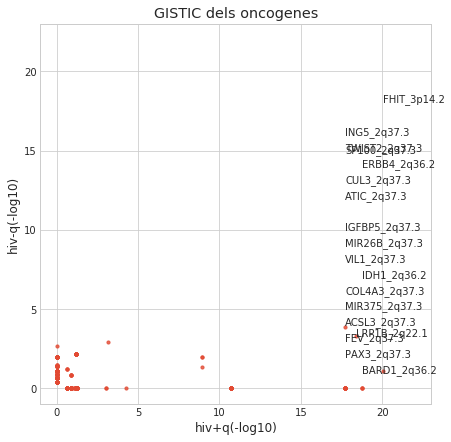

In [321]:
# Set theme
sns.set_style('whitegrid')


# Scatterplot arguments
# grid = sns.lmplot(x='hiv+q', y='hiv-q', data=ndf.fillna(.1),
#            fit_reg=False) # No regression line
#            #hue='Stage')   # Color by evolution stage
# # Tweak using Matplotlib
# # plt.ylim(0, .2)
# # plt.xlim(0, .2)
# grid.set(xscale="log", yscale="log")

f, ax = plt.subplots(figsize=(7, 7))


# ax.set(xscale="log", yscale="log")
sns.regplot(x='hiv+q(-log10)', y='hiv-q(-log10)', data=ndf, ax=ax, fit_reg=False, x_jitter=1e-12, y_jitter=1e-10, scatter_kws={"s": 10})




ax.set_title('GISTIC dels oncogenes')
ax.set_xlim(-1, 23)
ax.set_ylim(-1, 23)



    
ndf = ndf[(ndf['hiv+q(-log10)']>15)]#|(ndf['hiv-q(-log10)']>5)]
_ = label_point(ndf['hiv+q(-log10)'], ndf['hiv-q(-log10)'], ndf['gene']+'_'+ndf['cytoband'], plt.gca())  
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/del_gene_qvalue_comparison_hiv_pos_vs_neg.png'
plt.savefig(of, bbox_inches='tight', dpi=200)

In [126]:
plt.close()

In [18]:
ndf.head(2)

,hiv+q,gene,hiv-q
23,1.0,TP63,1.264200e-10
25,1.0,MYC,5.258800e-03


In [316]:
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/del_gene_qvalue_comparison_hiv_pos_vs_neg.txt'
ndf.to_csv(of, sep='\t', index=False)

In [9]:
%%bash
cd /home/szong/bin/GISTIC_2_0_22/124_patient_adj_hiv_neg
cat del_genes.conf_99.txt.summary |awk -F ":" '{print $1"\t"$2}'|sed 's/chr//g'|sort -k4n> del_genes.conf_99.txt.summary.sorted
cat amp_genes.conf_99.txt.summary |awk -F ":" '{print $1"\t"$2}'|sed 's/chr//g'|sort -k4n> amp_genes.conf_99.txt.summary.sorted

# look at correlation between copy number and expression

In [49]:
df2

,q value,gene,new_gene
7,3.377000e-03,"NFE2L2,HOXD11,HOXD13",NFE2L2
7,3.377000e-03,"NFE2L2,HOXD11,HOXD13",HOXD11
7,3.377000e-03,"NFE2L2,HOXD11,HOXD13",HOXD13
9,8.332900e-13,DLG1,DLG1
16,5.524600e-02,RAC1,RAC1
20,6.399600e-05,ESRP1,ESRP1
22,8.899700e-02,UHRF2,UHRF2
26,1.518200e-01,"LMO2,EHF",LMO2
26,1.518200e-01,"LMO2,EHF",EHF
28,5.902500e-07,"YAP1,BIRC3",YAP1


In [ ]:
f = '/home/szong/bin/GISTIC_2_0_22/124_patient_adj_3k_0.1_1Mb/all_thresholded.by_genes.txt'
df = pd.read_csv(f, sep='\t')
df.head(2)

In [ ]:
f1 = '/projects/trans_scratch/validations/workspace/szong/Cervical/expression/NCI_ensembl69_stranded_RPKM_matrix.txt'
df1 = pd.read_csv(f1, sep='\t')
df1.head(2)

In [ ]:
genes = ['ECT2', 'YAP1', 'DLG1',  'DNAH5',  'SP100', 'STK11']

In [ ]:
def categorize_cnv(i):
#     for i in s:
    if i < 0:
        cat = 'cnv_loss'
    elif i > 0:
        cat = 'cnv_gain'
    else: cat = 'cnv_neutral'
#         ns.append(cat)
    return cat

In [ ]:
with plt.style.context("seaborn-whitegrid"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25
    fig = plt.figure(facecolor='w', figsize=(12,12))
    axes = (fig.subplots(int(len(genes)/3), 3)).ravel()
#     print(axes[1])
    for i, gene in enumerate(genes):
        dfgene = df[df['Gene Symbol'] == gene]
        df1gene = df1[df1.genes.str.contains('_{}$'.format(gene))]
        dff = pd.concat([dfgene, df1gene]).drop(['Cytoband', 'Gene Symbol', 'Locus ID', 'genes'], axis=1).T
        dff.columns = ['cnv', 'rpkm']
#         dff['groups'] = ['cnv_loss' if i< 0 'cnv_gain' elif i>0 else 'cnv_neutral' for i in dff.cnv ]
        dff['groups'] = dff.cnv.apply(categorize_cnv)
#         print(dff['groups'].unique())
        # boxplot overlaps individual data point

        ax = axes[i]
        _ = sns.boxplot('groups', 'rpkm', data=dff, ax=ax, order=['cnv_loss', 'cnv_neutral', 'cnv_gain'])
        _ = sns.swarmplot('groups', 'rpkm', data=dff, ax=ax, order=['cnv_loss', 'cnv_neutral', 'cnv_gain'])
        _ = ax.set_title(gene)
        _ = ax.set_xlabel('')
        grps = {}
        # overlay actuall data point
        categories = ['cnv_loss','cnv_neutral', 'cnv_gain']
        group_col = 'groups'
        value_col = 'rpkm'
        for i, cat in enumerate(categories):
#             print(i, cat)
            grps[i] = dff.query('{0} == "{1}"'.format(group_col, cat))[value_col]

        if len(categories) == 2:
            # statistical test for 1st grp
#             sts, p = ss.mannwhitneyu(grps[0], grps[1], use_continuity=True, alternative=None)
            sts, p1 = ttest_ind(grps[0], grps[1])
#             print(p)
            p = round(p, 8)
            _ = ax.text(0.4 , 0.90,'p={}'.format(p), ha='center', va='center', transform=ax.transAxes, size=14)
        elif len(categories) == 3:
            # statistical test for 1st grp
#             sts, p1 = ss.mannwhitneyu(grps[0], grps[1], use_continuity=True, alternative=None)
            sts, p1 = ttest_ind(grps[0], grps[1])
#             print(p1)
            p1 = round(p1, 5)
            _ = ax.text(0.2 , 0.90,'p={}'.format(p1), ha='center', va='center', transform=ax.transAxes, size=14)
#             sts, p2 = ss.mannwhitneyu(grps[2], grps[1], use_continuity=True, alternative=None)
            sts, p2 = ttest_ind(grps[2], grps[1])
#             print(p2)
            p2 = round(p2, 5)
            _ = ax.text(0.7 , 0.90,'p={}'.format(p2), ha='center', va='center', transform=ax.transAxes, size=14)
    of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/cnv_expression.png'
    plt.savefig(of, dpi=200)